<a href="https://colab.research.google.com/github/hey-sid29/paddy-disease/blob/main/Nb2_Optimizing_Training_Time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook-2: Optimizing Training Time for Vision Models:

- This notebook is made to optimize the training time of models per epoch, from the notebook [Nb-1: Small Image Models](https://https://github.com/hey-sid29/Image-Models/blob/main/Nb_1_Small_Image_Models.ipynb)<br>
- This notebook shows an attempt to boost the accuracy of the selected model by fine-tuning it for longer epochs and adding better and more appropriate data preprocessing steps.

**Details**<br>

- Dataset used: [Paddy Disease Classification](https://www.kaggle.com/competitions/paddy-disease-classification/data)<br>
(Refer to the Notebook-1{link given above} for data description)

### 1. Setting up:

- Installing `fastkaggle` library
- Creating a Path Variable
- Setting up and downloading data

In [ ]:
#Setting up Kaggle folder

!mkdir ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
try:
  import fastkaggle
except ModuleNotFoundError:
  !pip install -Uq fastkaggle

from fastkaggle import *

In [ ]:
!pip install -Uq fastcore>=1.4.5
!pip install -Uq fastai>=2.7.1
!pip install -Uq timm>=0.6.2.dev0

In [ ]:
#Downloading Data:
data = "paddy-disease-classification"
path = setup_comp(data)

import timm
from fastai.vision.all import *
from pathlib import Path
#Setting seed value to reproduce same results:
set_seed(200)

100%|██████████| 1.02G/1.02G [00:15<00:00, 70.7MB/s]


In [ ]:
#Creating a Training Path:

train_path = Path('small')

### 2. Training base models:
- Resizing Images to reduce training time
- The images were mostly of (480,640) size
- Reducing the height and width of the images

In [ ]:
resize_images(path/'train_images', dest=train_path, max_size=256, recurse=True)

In [ ]:
#Creating DataLoaders:
dls = ImageDataLoaders.from_folder(train_path, valid_pct=0.3, seed=150, item_tfms=Resize((256, 192)))

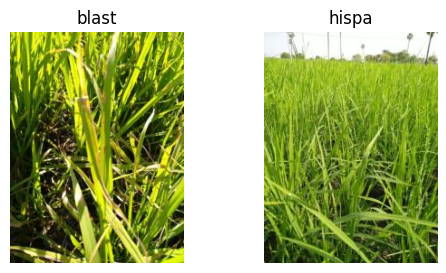

In [ ]:
dls.show_batch(max_n=2)

### 3. Experimenting with different model architectures:

In [ ]:
def train_model(arch, items, batch, epochs=5):
  dls = ImageDataLoaders.from_folder(train_path, seed=34, valid_pct=0.3, item_tfms=items, batch_tfms=batch)
  learner = vision_learner(dls, arch, metrics=error_rate).to_fp16()
  learner.fine_tune(epochs, 0.01) #Base Learning Rate=0.01
  return learner

1. Model: `Resnet26d`

In [ ]:
learner = train_model('resnet26d', items=Resize(192), batch=aug_transforms(size=128, min_scale=0.75))

model.safetensors:   0%|          | 0.00/64.2M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.981043,1.388107,0.453876,00:32


epoch,train_loss,valid_loss,error_rate,time
0,1.307055,1.063499,0.343049,00:29
1,1.083160,0.811632,0.259129,00:29
2,0.778681,0.523940,0.169122,00:29
3,0.582030,0.426459,0.133568,00:28
4,0.483633,0.415558,0.124920,00:28


**Inference**<br>
- The training time per epoch has improved vastly<br>


> Old Training Time per Epoch: 01:30 mins(approx.)


> New Training Time per Epoch: 00:29 secs(approx.)





2. Model: `ConvNeXt_Tiny_in22k`

In [ ]:
learner = train_model('convnext_tiny_in22k', items=Resize(192, method='squish'), batch=aug_transforms(size=128, min_scale=0.75))

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name convnext_tiny_in22k to current convnext_tiny.fb_in22k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/178M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.422186,0.831994,0.266176,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.748744,0.488601,0.159193,00:34
1,0.589762,0.410176,0.128764,00:35
2,0.380894,0.249043,0.074952,00:35
3,0.242522,0.182806,0.055093,00:34
4,0.171877,0.169305,0.052530,00:37


### 3. Preprocessing Steps:<br>
- Squishing
- Cropping
- Padding
- Test-Time Augmentation

- The base models have been trained on by `squishing` the images

- Cropping the Images:

In [ ]:
arch = 'convnext_tiny_in22k'

#Crop is default for fastai, hence no specific has been passed in Resize() function-
learner = train_model(arch, items=Resize(192), batch=aug_transforms(size=128, min_scale=0.75))


epoch,train_loss,valid_loss,error_rate,time
0,1.428332,1.063717,0.292761,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.832957,0.550380,0.179052,00:34
1,0.636272,0.452479,0.140295,00:33
2,0.436864,0.304745,0.092569,00:35
3,0.289680,0.209666,0.066304,00:33
4,0.211986,0.187486,0.057976,00:33


* Because of cropping, there is a possible loss of information, hence the accuracy decreases somewhat

- Padding the images:

In [ ]:
learner = train_model(arch, items=Resize((256, 192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
                      batch=aug_transforms(size=(171, 128), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.370743,0.797482,0.257848,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.765343,0.595531,0.183216,00:34
1,0.624033,0.366185,0.119475,00:35
2,0.434938,0.252071,0.080397,00:34
3,0.245303,0.184494,0.053812,00:35
4,0.167155,0.169171,0.052210,00:35


- Test-Time Augmentation[TTA]:

In [ ]:
valid_set = learner.dls.valid

preds, targets = learner.get_preds(dl=valid_set)

In [ ]:
error_rate(preds, targets)

TensorBase(0.0522)

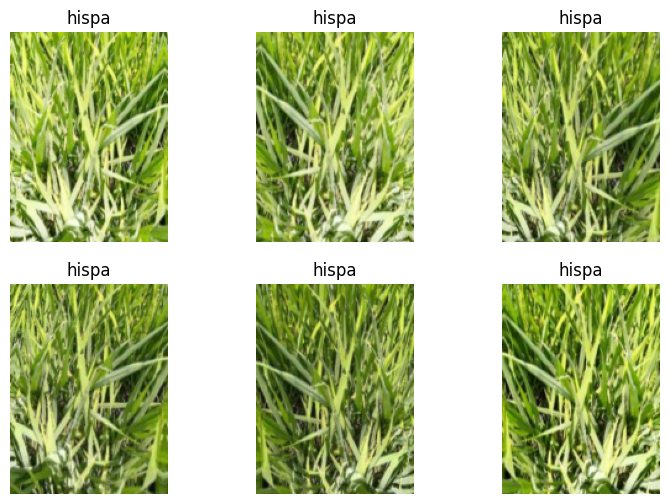

In [ ]:
learner.dls.train.show_batch(max_n=6, unique=True)

In [ ]:
tta_preds, _ = learner.tta(dl=valid_set)

In [ ]:
error_rate(tta_preds, targets)

TensorBase(0.0464)

The model's `error_rate` has been improved from `0.0490`(Images were just padded with zeros) to `0.0413`(with Test-Time Augmentation)<br>
The accuracy of the model has been improved vastly

### Creating the Final version of the model:

In [ ]:
train_path = path/'train_images'

In [ ]:
learner = train_model(arch, epochs=15,
                      items=Resize((480, 360), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
                      batch=aug_transforms(size=(256, 192), min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.128837,0.622388,0.199552,01:39


epoch,train_loss,valid_loss,error_rate,time
0,0.586619,0.331944,0.103780,01:41
1,0.437113,0.320114,0.103139,01:40
2,0.370067,0.350891,0.114350,01:40
3,0.360775,0.368995,0.119475,01:41
4,0.282855,0.197977,0.054132,01:41
5,0.234675,0.168410,0.051890,01:39
6,0.197332,0.185860,0.056374,01:40
7,0.159890,0.167080,0.045163,01:39
8,0.122288,0.129287,0.032992,01:41
9,0.101625,0.103849,0.029148,01:38


In [ ]:
#Adding the Test-Time Augmentation[TTA] step:

tta_preds, targs = learner.tta(dl=learner.dls.valid)
error_rate(tta_preds, targs)


TensorBase(0.0218)

### Model Performance on Test Set:

In [ ]:
test_files = get_image_files(path/'test_images').sorted()
test_dls = learner.dls.test_dl(test_files)

In [ ]:
preds, _ = learner.tta(dl=test_dls)


- Including the top probablities for every prediction:

In [ ]:
idxs = preds.argmax(dim=1)

In [ ]:
vocab = np.array(learner.dls.vocab)

results = pd.Series(vocab[idxs], name='idxs')

In [ ]:
## Creating the submission file

ss = pd.read_csv(path/'sample_submission.csv')
ss['label'] = results
ss.to_csv('submit_final.csv', index=False)
!head submit_final.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,blast
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa


### Score on Competition:<br>

- Private Score: `0.978`<br>
- Public Score: `0.973`